In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Dataset

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    
)

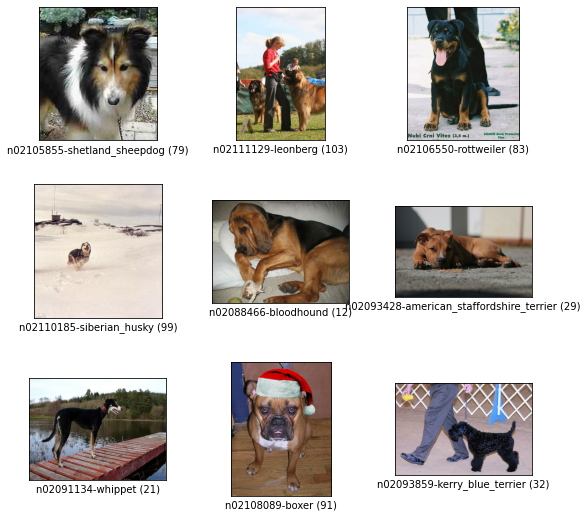

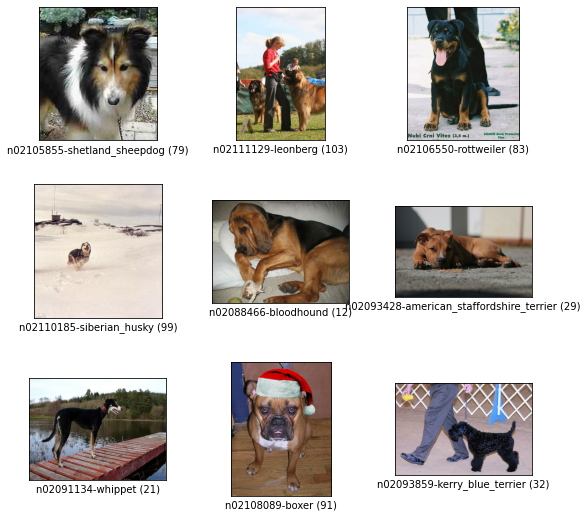

In [6]:
tfds.show_examples(ds_train, ds_info)

# 2. albumentations

In [7]:
# 라벨 수 가져오기
num_classes = ds_info.features['label'].num_classes  

In [8]:
import albumentations as A

# Albumentations 증강을 적용하기 위한 함수
def aug_fn(image):
    # 이미지를 NumPy로 변환
    image = image.numpy()

    # Albumentations 증강 적용
    transform = A.Compose([
        A.RandomBrightnessContrast(p=0.2),
        A.HueSaturationValue(p=0.2),
    ])
    
    augmented = transform(image=image)
    return augmented['image']

# 텐서를 NumPy로 변환하여 Albumentations 증강을 적용한 후 다시 텐서로 변환
def augment(image, label):
    # tf.py_function을 사용하여 NumPy 변환 후 Albumentations 적용
    aug_image = tf.py_function(func=aug_fn, inp=[image], Tout=tf.float32)
    aug_image.set_shape([224, 224, 3])  # 출력 이미지 크기 설정
    return aug_image, label

In [9]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label


def onehot(image, label):
    
    if label.dtype == tf.float32:
        label = tf.cast(label, tf.int32)
        
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [10]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


In [11]:
ds_train_no_aug

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

In [12]:
ds_train_aug

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

In [13]:
ds_test

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

## Augmentation에 의한 모델 성능 비교
- No Augmentation
- 기본 Augmentation
- No Augmentation + CutMix 적용
- No Augmentation + Mixup 적용

In [15]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')


# 가중치 저장 경로 설정
checkpoint_path = "./resnet50_no_aug_weights.{epoch:02d}-{val_loss:.2f}.h5"

# ModelCheckpoint 콜백 설정
no_aug_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # 가중치만 저장
    monitor='val_loss',  # 검증 손실에 따라 저장
    save_best_only=True,  # 가장 성능이 좋은 모델만 저장
    verbose=1
)

EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

resnet50.compile(
#     loss='sparse_categorical_crossentropy',
    loss='categorical_crossentropy',    
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


=3


In [20]:
# 모델 학습 (가중치 저장 포함)
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[no_aug_checkpoint]  # 콜백 추가
)

Epoch 1/20


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


750/750 [==============================] - 167s 207ms/step - loss: 2.2181 - accuracy: 0.4430 - val_loss: 3.1645 - val_accuracy: 0.2499

Epoch 00001: val_loss improved from inf to 3.16446, saving model to ./resnet50_no_aug_weights.01-3.16.h5
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 0.7319 - accuracy: 0.7972 - val_loss: 1.1508 - val_accuracy: 0.6643

Epoch 00002: val_loss improved from 3.16446 to 1.15082, saving model to ./resnet50_no_aug_weights.02-1.15.h5
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2201 - accuracy: 0.9557 - val_loss: 0.9729 - val_accuracy: 0.7135

Epoch 00003: val_loss improved from 1.15082 to 0.97286, saving model to ./resnet50_no_aug_weights.03-0.97.h5
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0685 - accuracy: 0.9929 - val_loss: 0.9310 - val_accuracy: 0.7337

Epoch 00004: val_loss improved from 0.97286 to 0.93104, saving model to ./resnet50_no_aug_weights.04

- 예상 : 증강 안한 기본 데이터셋으로 resnet50 모델 테스트 -> baseline model
- 결과 : 4epoch 에서 val_loss가 0.93 달성 -> 그 이후로는 overfitting
- 분석 : 데이터 증강 후 데이터셋이 더 풍부해지므로 학습의 일반화 성능이 향상 예상 => overfitting을 늦출 수 있다

In [12]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

# 가중치 저장 경로 설정
checkpoint_path = "./resnet50_aug_weights.{epoch:02d}-{val_loss:.2f}.h5"

# ModelCheckpoint 콜백 설정
aug_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # 가중치만 저장
    monitor='val_loss',  # 검증 손실에 따라 저장
    save_best_only=True,  # 가장 성능이 좋은 모델만 저장
    verbose=1
)



=3


In [22]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[aug_checkpoint]  # 콜백 추가    
)

Epoch 1/20
750/750 [==============================] - 178s 225ms/step - loss: 2.9115 - accuracy: 0.3179 - val_loss: 2.6870 - val_accuracy: 0.3064

Epoch 00001: val_loss improved from inf to 2.68700, saving model to ./resnet50_aug_weights.01-2.69.h5
Epoch 2/20
750/750 [==============================] - 167s 223ms/step - loss: 1.7312 - accuracy: 0.5794 - val_loss: 1.3734 - val_accuracy: 0.6109

Epoch 00002: val_loss improved from 2.68700 to 1.37340, saving model to ./resnet50_aug_weights.02-1.37.h5
Epoch 3/20
750/750 [==============================] - 167s 223ms/step - loss: 1.3329 - accuracy: 0.6976 - val_loss: 1.3371 - val_accuracy: 0.6319

Epoch 00003: val_loss improved from 1.37340 to 1.33712, saving model to ./resnet50_aug_weights.03-1.34.h5
Epoch 4/20
750/750 [==============================] - 182s 243ms/step - loss: 1.1258 - accuracy: 0.7544 - val_loss: 1.4366 - val_accuracy: 0.6026

Epoch 00004: val_loss did not improve from 1.33712
Epoch 5/20
750/750 [===========================

- 증강 후의 모델 성능이 어떻게 나올까?

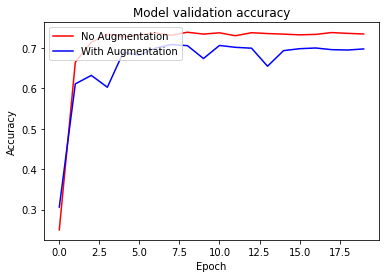

In [32]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

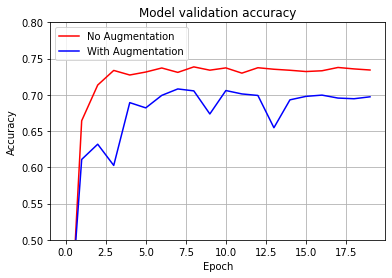

In [27]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
# plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

- 증강 후에는 8 epoch 때도 val_loss가 1.10 

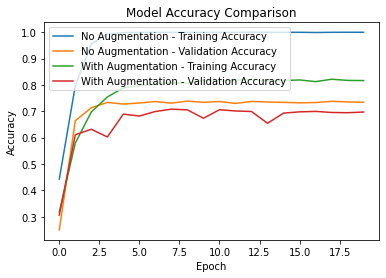

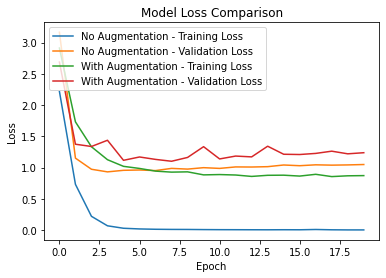

In [33]:
import matplotlib.pyplot as plt

# 학습 정확도 및 검증 정확도 시각화
def plot_accuracy(history1, history2, label1="No Augmentation", label2="With Augmentation"):
    plt.plot(history1.history['accuracy'], label=f'{label1} - Training Accuracy')
    plt.plot(history1.history['val_accuracy'], label=f'{label1} - Validation Accuracy')
    plt.plot(history2.history['accuracy'], label=f'{label2} - Training Accuracy')
    plt.plot(history2.history['val_accuracy'], label=f'{label2} - Validation Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

# 학습 손실 및 검증 손실 시각화
def plot_loss(history1, history2, label1="No Augmentation", label2="With Augmentation"):
    plt.plot(history1.history['loss'], label=f'{label1} - Training Loss')
    plt.plot(history1.history['val_loss'], label=f'{label1} - Validation Loss')
    plt.plot(history2.history['loss'], label=f'{label2} - Training Loss')
    plt.plot(history2.history['val_loss'], label=f'{label2} - Validation Loss')
    plt.title('Model Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

# 성능 비교 시각화
plot_accuracy(history_resnet50_no_aug, history_resnet50_aug)
plot_loss(history_resnet50_no_aug, history_resnet50_aug)


- 증강 전 : 1epoch 만에 빠르게 train acc가 높아지지지만, val acc와 차이가 너무 큼 -> 학습에만 과적합 되고 있는게 아닐까?
- 증강 후 : train acc와 val acc가 큰 차이 안남 -> 학습이 더 잘 되고 있는게 아닐까?

# 3. CutMix

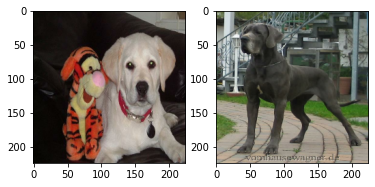

In [14]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
        
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [15]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [16]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(60, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(107, shape=(), dtype=int32)


In [17]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

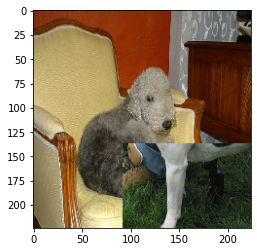

In [48]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [18]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [19]:
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.65027106, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [20]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        # Mix 영역 설정
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    
    return mixed_imgs, mixed_labels

print('=3')

=3


In [21]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, is_test=False, with_cutmix=True)
print('=3')

=3


In [22]:
ds_train_cutmix

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

In [23]:
ds_test

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

In [23]:
'''
apply_normalize_on_dataset 함수의 역할:
is_test=True일 때:
데이터 증강 없음: 테스트 데이터에는 증강이나 섞기(shuffling)를 적용하지 않고, 데이터 순서가 유지됩니다.
반복 없음: repeat() 함수도 적용되지 않으므로 테스트 데이터는 한 번만 평가됩니다.
기본 전처리만 수행: 이미지 리사이즈 및 정규화 같은 기본적인 전처리만 수행됩니다.
'''

'\napply_normalize_on_dataset 함수의 역할:\nis_test=True일 때:\n데이터 증강 없음: 테스트 데이터에는 증강이나 섞기(shuffling)를 적용하지 않고, 데이터 순서가 유지됩니다.\n반복 없음: repeat() 함수도 적용되지 않으므로 테스트 데이터는 한 번만 평가됩니다.\n기본 전처리만 수행: 이미지 리사이즈 및 정규화 같은 기본적인 전처리만 수행됩니다.\n'

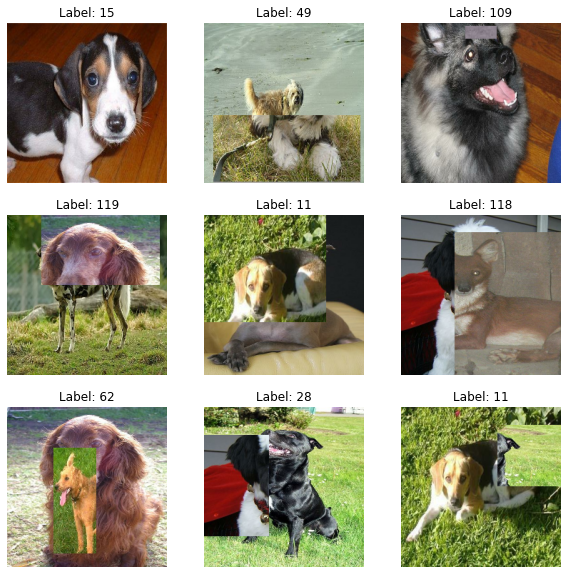

In [24]:
# ds_train_cutmix에서 첫 번째 배치 가져오기
for images, labels in ds_train_cutmix.take(1):  
    plt.figure(figsize=(10, 10))
    
    # 배치에서 9개의 이미지를 출력
    for i in range(9):
        plt.subplot(3, 3, i+1)
        
        # 이미지 시각화
        plt.imshow(images[i].numpy())
        
        # 라벨 출력
        label = np.argmax(labels[i].numpy())  # 라벨이 원-핫 인코딩된 경우 argmax로 클래스 인덱스 가져오기
        plt.title(f"Label: {label}")
        plt.axis('off')
        
    plt.show()


In [25]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

EPOCH = 20 


# 가중치 저장 경로 설정
checkpoint_path = "./resnet50_cutmix_weights.{epoch:02d}-{val_loss:.2f}.h5"

# ModelCheckpoint 콜백 설정
cutmix_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # 가중치만 저장
    monitor='val_loss',  # 검증 손실에 따라 저장
    save_best_only=True,  # 가장 성능이 좋은 모델만 저장
    verbose=1
)

cutmix_resnet50.compile(
#     loss='sparse_categorical_crossentropy',
    loss='categorical_crossentropy',    
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


=3


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [24]:
# 모델 학습 (가중치 저장 포함)
history_cutmix_resnet50_aug = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix dataset
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
    callbacks=[cutmix_checkpoint]  # 콜백 추가
)


Epoch 1/20
750/750 - 209s - loss: 3.7962 - accuracy: 0.2210 - val_loss: 3.2849 - val_accuracy: 0.2278

Epoch 00001: val_loss improved from inf to 3.28492, saving model to ./resnet50_cutmix_weights.01-3.28.h5
Epoch 2/20
750/750 - 165s - loss: 2.9227 - accuracy: 0.4387 - val_loss: 1.3374 - val_accuracy: 0.6332

Epoch 00002: val_loss improved from 3.28492 to 1.33740, saving model to ./resnet50_cutmix_weights.02-1.34.h5
Epoch 3/20
750/750 - 160s - loss: 2.6149 - accuracy: 0.5396 - val_loss: 1.2288 - val_accuracy: 0.6542

Epoch 00003: val_loss improved from 1.33740 to 1.22882, saving model to ./resnet50_cutmix_weights.03-1.23.h5
Epoch 4/20
750/750 - 155s - loss: 2.4042 - accuracy: 0.6077 - val_loss: 1.1914 - val_accuracy: 0.6677

Epoch 00004: val_loss improved from 1.22882 to 1.19141, saving model to ./resnet50_cutmix_weights.04-1.19.h5
Epoch 5/20
750/750 - 156s - loss: 2.2457 - accuracy: 0.6610 - val_loss: 1.2308 - val_accuracy: 0.6580

Epoch 00005: val_loss did not improve from 1.19141
Ep

- 예상 : 사람이 육안으로 봐도 헷갈리는게 많은데 과연 학습에 도움이 될까?
- cutmix, mixup 추가 이유 : noise를 추가해서 model에 일반화 성능 향상 기대 -> robust한 model

# 4. Mixup

In [26]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

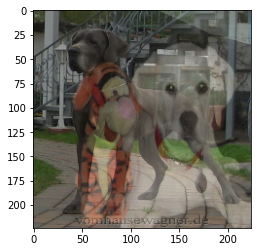

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.4219104 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.5780896 0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [27]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [29]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [30]:
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=False)

In [37]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

EPOCH = 20 


# 가중치 저장 경로 설정
checkpoint_path = "./resnet50_mixup_weights.{epoch:02d}-{val_loss:.2f}.h5"

# ModelCheckpoint 콜백 설정
mixup_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # 가중치만 저장
    monitor='val_loss',  # 검증 손실에 따라 저장
    save_best_only=True,  # 가장 성능이 좋은 모델만 저장
    verbose=1
)

mixup_resnet50.compile(
#     loss='sparse_categorical_crossentropy',
    loss='categorical_crossentropy',    
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

=3


In [38]:
# 모델 학습 (가중치 저장 포함)
history_mixup_resnet50_aug = mixup_resnet50.fit(
#     ds_train_no_aug, # 변경 필요
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
    callbacks=[mixup_checkpoint]  # 콜백 추가
)


Epoch 1/20
750/750 - 160s - loss: 2.2098 - accuracy: 0.4505 - val_loss: 3.4503 - val_accuracy: 0.1938

Epoch 00001: val_loss improved from inf to 3.45029, saving model to ./resnet50_mixup_weights.01-3.45.h5
Epoch 2/20
750/750 - 153s - loss: 0.6866 - accuracy: 0.8152 - val_loss: 1.1858 - val_accuracy: 0.6562

Epoch 00002: val_loss improved from 3.45029 to 1.18581, saving model to ./resnet50_mixup_weights.02-1.19.h5
Epoch 3/20
750/750 - 153s - loss: 0.2156 - accuracy: 0.9557 - val_loss: 0.9550 - val_accuracy: 0.7192

Epoch 00003: val_loss improved from 1.18581 to 0.95503, saving model to ./resnet50_mixup_weights.03-0.96.h5
Epoch 4/20
750/750 - 152s - loss: 0.0560 - accuracy: 0.9960 - val_loss: 0.9379 - val_accuracy: 0.7306

Epoch 00004: val_loss improved from 0.95503 to 0.93787, saving model to ./resnet50_mixup_weights.04-0.94.h5
Epoch 5/20
750/750 - 152s - loss: 0.0255 - accuracy: 0.9992 - val_loss: 0.9268 - val_accuracy: 0.7382

Epoch 00005: val_loss improved from 0.93787 to 0.92681, s

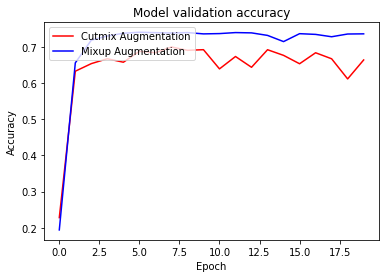

In [39]:
plt.plot(history_cutmix_resnet50_aug.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Cutmix Augmentation', 'Mixup Augmentation'], loc='upper left')
plt.show()

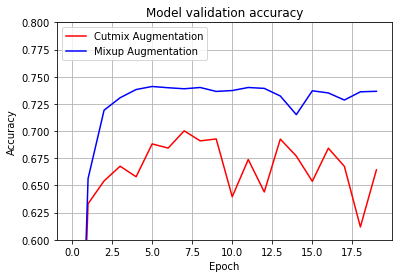

In [42]:
plt.plot(history_cutmix_resnet50_aug.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Cutmix Augmentation', 'Mixup Augmentation'], loc='upper left')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.60, 0.80)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

# 5. Comparison

- no aumentation / argumentation(brigthne

In [11]:
def load_model():
    base_model = tf.keras.applications.ResNet50(
        include_top=False,  # 마지막 밀집 레이어 포함 X
        weights=None,  # 사전 학습된 가중치 사용 안 함
        input_shape=(224, 224, 3)
    )
    # 필요한 추가 레이어를 쌓음 (ex: 밀집 레이어)
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(120, activation='softmax')  # 클래스 수에 맞게 설정
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy']
    )
    return model


In [12]:
model = load_model()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


In [13]:
for images, labels in ds_test.take(1):
    print("Images shape:", images.shape)  # 올바른 형태: (batch_size, 224, 224, 3)
    print("Labels shape:", labels.shape)  # 올바른 형태: (batch_size, 120)


Images shape: (16, 224, 224, 3)
Labels shape: (16, 120)


In [33]:
# ResNet50 모델 정의 (가중치 로드용)
def load_model():
    model = tf.keras.applications.ResNet50(
        include_top=True,  # 마지막 레이어 포함
        weights=None,  # 사전 학습된 가중치 사용 안 함
        input_shape=(224, 224, 3),
        classes=120  # 클래스 수는 사용자의 데이터셋에 맞게 설정
    )
    model.compile(
        loss='categorical_crossentropy',  # 각 모델에 맞는 loss 사용
        optimizer=tf.keras.optimizers.SGD(lr=0.01),
        metrics=['accuracy']
    )
    return model

# 가중치 경로 설정
weights = {
#     "No Augmentation": "./resnet50_no_aug_weights.04-0.93.h5",
#     "With Augmentation": "./resnet50_aug_weights.08-1.10.h5",
    "With CutMix": "./resnet50_cutmix_weights.08-1.15.h5",
    "With MixUp": "./resnet50_mixup_weights.05-0.93.h5"
}

# 결과 저장할 딕셔너리
results = {}

# 가중치별 성능 평가
for name, weight_path in weights.items():
    print('name', name)
    model = load_model()  
    model.load_weights(weight_path, by_name=True)
    loss, acc = model.evaluate(ds_test, verbose=0)  # 검증 데이터셋에서 평가
    results[name] = {"loss": loss, "accuracy": acc}  # 성능 저장


name With CutMix
name With MixUp


In [34]:
results

{'With CutMix': {'loss': 4.788447856903076, 'accuracy': 0.0060606058686971664},
 'With MixUp': {'loss': 4.789377689361572, 'accuracy': 0.010722611099481583}}

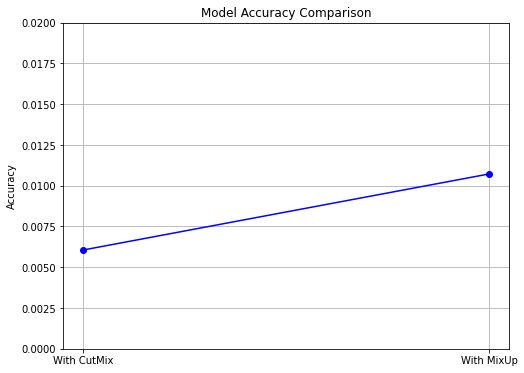

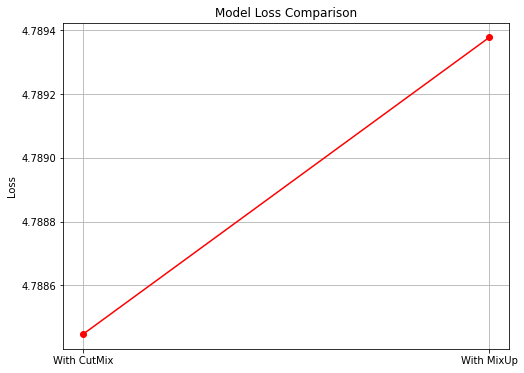

In [35]:
# 정확도 비교 
def plot_accuracy(results):
    model_names = list(results.keys())  # 모델 이름
    accuracy_values = [results[model]["accuracy"] for model in model_names]  # 각 모델의 정확도

    plt.figure(figsize=(8, 6))
    plt.plot(model_names, accuracy_values, marker='o', linestyle='-', color='b')
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.ylim(0, 0.02)  # 정확도가 낮으므로 범위를 조정
    plt.grid(True)
    plt.show()

# 손실 비교 
def plot_loss(results):
    model_names = list(results.keys())  # 모델 이름
    loss_values = [results[model]["loss"] for model in model_names]  # 각 모델의 손실

    plt.figure(figsize=(8, 6))
    plt.plot(model_names, loss_values, marker='o', linestyle='-', color='r')
    plt.title("Model Loss Comparison")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# 그래프 출력
plot_accuracy(results)
plot_loss(results)


- 다음부턴 weight만 저장하지 말자...
- csv_logger 사용해서 callbacks=[mixup_checkpoint,csv_logger] 저장하기

# 6. Additional

In [37]:
from tensorflow.keras.callbacks import CSVLogger

In [38]:
# 각 모델에 대해 추가 학습할 에포크 설정
additional_epochs = 10

# 1. No Augmentation 모델 추가 학습
model_no_aug = load_model()  # 모델 로드
model_no_aug.load_weights("./resnet50_no_aug_weights.04-0.93.h5",  by_name=True)  # 기존 가중치 로드
csv_logger_no_aug = CSVLogger('training_no_aug.csv', append=True)

history_no_aug_additional = model_no_aug.fit(
    ds_train_no_aug,  # augmentation 없는 데이터셋
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_data=ds_test,
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=additional_epochs,  # 추가 에포크 수
    verbose=1,
    use_multiprocessing=True,  # 멀티프로세싱 활성화
    callbacks=[csv_logger_no_aug]  # CSVLogger 콜백 추가
)
model_no_aug.save_weights("resnet50_no_aug_additional_weights.h5")  # 새로운 가중치 저장

# 2. With Augmentation 모델 추가 학습
model_aug = load_model()
model_aug.load_weights("./resnet50_aug_weights.08-1.10.h5",  by_name=True)
csv_logger_aug = CSVLogger('training_aug.csv', append=True)

history_aug_additional = model_aug.fit(
    ds_train_aug,  # augmentation 적용된 데이터셋
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_data=ds_test,
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=additional_epochs,
    verbose=1,
    use_multiprocessing=True,  # 멀티프로세싱 활성화
    callbacks=[csv_logger_aug]
)
model_aug.save_weights("resnet50_aug_additional_weights.h5")

# 3. With CutMix 모델 추가 학습
model_cutmix = load_model()
model_cutmix.load_weights("./resnet50_cutmix_weights.08-1.15.h5",  by_name=True)
csv_logger_cutmix = CSVLogger('training_cutmix.csv', append=True)

history_cutmix_additional = model_cutmix.fit(
    ds_train_cutmix,  # cutmix 데이터셋
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_data=ds_test,
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=additional_epochs,
    verbose=1,
    use_multiprocessing=True,  # 멀티프로세싱 활성화
    callbacks=[csv_logger_cutmix]
)
model_cutmix.save_weights("resnet50_cutmix_additional_weights.h5")

# 4. With MixUp 모델 추가 학습
model_mixup = load_model()
model_mixup.load_weights("./resnet50_mixup_weights.05-0.93.h5",  by_name=True)
csv_logger_mixup = CSVLogger('training_mixup.csv', append=True)

history_mixup_additional = model_mixup.fit(
    ds_train_mixup,  # mixup 데이터셋
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_data=ds_test,
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=additional_epochs,
    verbose=1,
    use_multiprocessing=True,  # 멀티프로세싱 활성화
    callbacks=[csv_logger_mixup]
)
model_mixup.save_weights("resnet50_mixup_additional_weights.h5")


Epoch 1/10
750/750 [==============================] - 170s 211ms/step - loss: 5.1607 - accuracy: 0.0104 - val_loss: 5.3027 - val_accuracy: 0.0093
Epoch 2/10
750/750 [==============================] - 157s 209ms/step - loss: 4.8794 - accuracy: 0.0143 - val_loss: 4.8968 - val_accuracy: 0.0225
Epoch 3/10
750/750 [==============================] - 157s 209ms/step - loss: 4.7564 - accuracy: 0.0184 - val_loss: 4.6195 - val_accuracy: 0.0203
Epoch 4/10
750/750 [==============================] - 157s 209ms/step - loss: 4.6773 - accuracy: 0.0259 - val_loss: 5.0554 - val_accuracy: 0.0322
Epoch 5/10
750/750 [==============================] - 157s 209ms/step - loss: 4.6333 - accuracy: 0.0295 - val_loss: 4.7955 - val_accuracy: 0.0377
Epoch 6/10
750/750 [==============================] - 157s 209ms/step - loss: 4.5823 - accuracy: 0.0356 - val_loss: 4.5644 - val_accuracy: 0.0454
Epoch 7/10
750/750 [==============================] - 157s 209ms/step - loss: 4.5540 - accuracy: 0.0345 - val_loss: 4.9817 -

In [42]:
import pandas as pd

# CSV 파일에서 데이터 불러오기
history_no_aug = pd.read_csv('training_no_aug.csv')
history_aug = pd.read_csv('training_aug.csv')
history_cutmix = pd.read_csv('training_cutmix.csv')
history_mixup = pd.read_csv('training_mixup.csv')


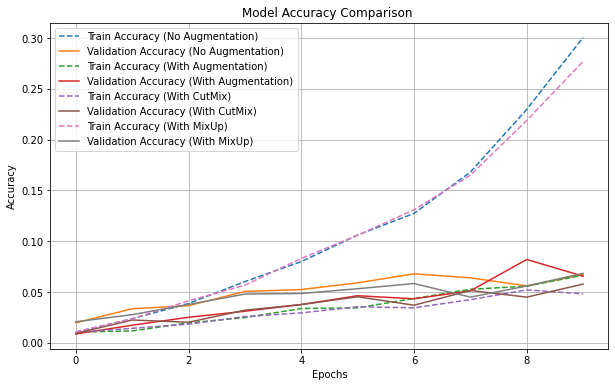

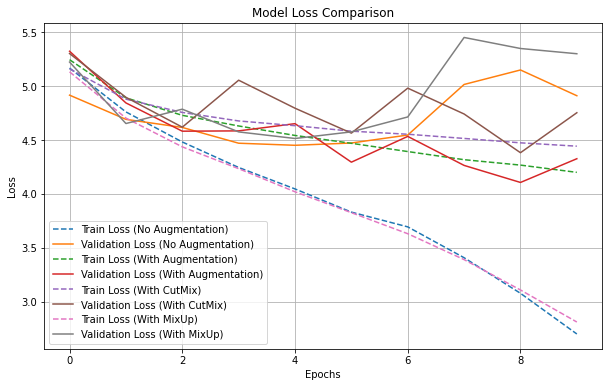

In [45]:
# 정확도 시각화 함수
def plot_accuracy_from_csv(histories, labels):
    plt.figure(figsize=(10, 6))
    
    for i, history in enumerate(histories):
        plt.plot(history['accuracy'], label=f'Train Accuracy ({labels[i]})', linestyle='--')
        plt.plot(history['val_accuracy'], label=f'Validation Accuracy ({labels[i]})')

    plt.title('Model Accuracy Comparison ')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# 손실 시각화 함수
def plot_loss_from_csv(histories, labels):
    plt.figure(figsize=(10, 6))
    
    for i, history in enumerate(histories):
        plt.plot(history['loss'], label=f'Train Loss ({labels[i]})', linestyle='--')
        plt.plot(history['val_loss'], label=f'Validation Loss ({labels[i]})')

    plt.title('Model Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 4개의 CSV 데이터프레임과 라벨
histories = [history_no_aug, history_aug, history_cutmix, history_mixup]
labels = ['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp']

# 정확도 및 손실 그래프 출력
plot_accuracy_from_csv(histories, labels)
plot_loss_from_csv(histories, labels)


# 7.Review

- feedback
- 모델 한번 돌렸을 때 시간이 얼마나 걸릴까 측정 필요
- 가장 간단한 모델에서 overfitting 확인 필요
- 시간 압축 : lr 키우기 조정, lr scheduller 사용, input_size 줄이기

- 다음엔 tqdm을 써서 시간을 좀 제대로 확인해보자